<img src="./images/logo-ensae.jpg" width = 40%><img src="./images/logo-ipparis.jpg" width = 30%>

**"Geometric Methods in Machine Learning", S2 2018-19** 
# *Studying Time Series using Dynamic Time Warping*  

**Yosuke IJIRI**, *Mastère Spécialisé Data Science, ENSAE ParisTech*  

## Overview

In [654]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Instructions
Download the Sales Transactions Weekly Dataset. You will recover 800 time series of sales of different products with 52 timestamps (one for each week). Alternatively, you can also download any other dataset of your liking, with the same type, i.e. labelled time series, with a few hundreds or thousands of time series of moderate length.  
  
**Outcome:** A zip file containing your report in pdf (not a .doc) and code in whatever format (you can send a notebook).

## 1. Data Preparation

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from IPython.display import HTML
import itertools
import time

In [2]:
df = pd.read_csv('./data/Sales_Transactions_Dataset_Weekly.csv')
df.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [3]:
# Take out the normalized values from the dataframe
idx = [i for i in range(df.shape[1]) if 'Normalized' in df.columns[i]]
ndf = df.iloc[:, idx]
ndf.head()

,Normalized 0,Normalized 1,Normalized 2,Normalized 3,Normalized 4,Normalized 5,Normalized 6,Normalized 7,Normalized 8,Normalized 9,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,0.44,0.50,0.39,0.28,0.56,0.50,0.61,1.00,0.17,0.61,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,0.70,0.60,0.30,0.20,0.70,0.10,0.60,0.30,0.30,0.30,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,0.36,0.73,0.45,0.55,0.64,0.45,0.36,0.91,0.82,0.27,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,0.59,0.35,0.65,0.18,0.41,0.24,0.41,0.65,0.65,0.53,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,0.33,0.13,0.67,0.53,0.20,0.27,0.40,0.73,0.40,0.40,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [4]:
# Transform the data from dataframe to numpy.ndarry
data = ndf.values
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(811, 52)


## 2. Dynamic Time Warping
**Objective: Implement the dynamic time warping distance in your programming language of choice.**

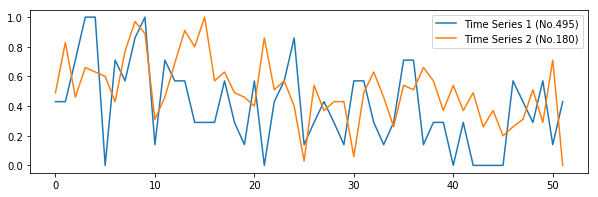

In [50]:
# Plot two sample time series that are chosen randomly
samples = random.sample(range(data.shape[0]), 2)
ts1 = data[samples[0]]
ts2 = data[samples[1]]
plt.figure(figsize = (10, 3))
plt.plot(ts1, label="Time Series 1 (No.%d)"%samples[0])
plt.plot(ts2, label="Time Series 2 (No.%d)"%samples[1])
plt.legend()
plt.savefig('./data/sample_time_series.png')
plt.show()

In [6]:
def DTW(x, y):
    '''
    Returns the Path Cost matrix and the DTW distance
    '''
    nrow = len(x)  # 52
    ncol = len(y)  # 52
    
    # Initialise the cost matrix
    C = np.zeros([nrow,ncol])
    C[0, :], C[:, 0] = np.infty, np.infty
    C[0,0] = 0
    
    # Bellman Recursion
    for i in range(nrow-1):
        for j in range(ncol-1):
            D = np.abs(x[i] - y[j])
            C[i+1][j+1] = D + np.min([C[i+1][j], C[i][j], C[i][j+1]])
    
    return C

In [7]:
def opt_path(dtw):
    '''
    Returns the optimal path
    '''
    rlen = dtw.shape[0]
    clen = dtw.shape[1]
    
    r = rlen-1
    c = clen-1

    # Initialise the paths
    r_path = [r]
    c_path = [c]
    cost_path = [dtw[r,c]]   

    while (r!=0 or c!=0):
        cost_temp = dtw[r, c]
    
        if dtw[r, c-1] <= cost_temp:
            r_temp = r
            c_temp = c-1
            cost_temp = dtw[r, c-1]    
        if dtw[r-1, c-1] <= cost_temp:
            r_temp = r-1
            c_temp = c-1
            cost_temp = dtw[r-1, c-1] 
        if dtw[r-1, c] <= cost_temp:
            r_temp = r-1
            c_temp = c
            cost_temp = dtw[r-1, c]
        
        r = r_temp
        c = c_temp
        r_path += [r]
        c_path += [c]
        cost_path += [cost_temp]
        
    r_path = list(reversed(r_path))[1:]
    c_path = list(reversed(c_path))[1:]
    cost_path = list(reversed(cost_path))[1:]

    return(r_path, c_path, cost_path, rlen, clen)

In [54]:
def opt_path_vis(r_path, c_path, cost_path, rlen, clen):
    '''
    Visualisation of the Optimal Path
    '''
    nrow = rlen
    ncol = clen

    plt.figure(figsize=(rlen/2,clen/2))
    plt.scatter(np.array(r_path),np.array(c_path), s=250, label="Optimal Path Points (cost)")
    plt.xlim(0,clen-.5)
    plt.ylim(rlen-.5,0)
    for i in range(nrow):
        plt.axhline(i+1, linestyle='-', color='lightgray')
        plt.axvline(i+1, linestyle='-', color='lightgray')
    for i in range(len(r_path)):
        plt.annotate(s="("+str(round(cost_path[i], 2))+")", xy=(r_path[i]+0.1,c_path[i]-0.5))
    plt.xticks(range(ncol))
    plt.yticks(range(nrow))
    plt.xlabel("Time Series 1 (No.%d)"%samples[0], fontsize=30)
    plt.ylabel("Time Series 2 (No.%d)"%samples[1], fontsize=30)
    plt.title("Optimal Path", fontsize=35)
    plt.legend()
    plt.savefig('./data/optimal_path.png')

In [56]:
def opt_path_ladder(ts1, ts2, r_path, c_path):
    '''
    Visualisation of the Optimal Path Ladder
    '''
    plt.figure(figsize = (10, 3))
    plt.plot(ts1, label="Time Series 1 (No.%d)"%samples[0])
    plt.plot(ts2, label="Time Series 2 (No.%d)"%samples[1] )

    r_path = res[0]
    c_path = res[1]

    for i in range(len(r_path)):
        a = [r_path[i]-1,c_path[i]-1]
        b = [ts1[r_path[i]-1],ts2[c_path[i]-1]]
        plt.plot(a, b, color="lightcoral", linewidth=.5 )
    
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    plt.grid(False)
    plt.title("Optimal Path Ladder")
    plt.legend()
    plt.savefig('./data/optimal_path_ladder.png')

In [10]:
def dtw_method(ts1, ts2):
    '''
    Set of the two functions
    '''
    dtw = DTW(ts1, ts2)
    res = opt_path(dtw)
    return res

In [11]:
def dtw_method_vis(res):
    '''
    Set of the two visualisation functions
    '''
    opt_path_vis(res[0],res[1],res[2],res[3],res[4])
    plt.close()
    opt_path_ladder(ts1, ts2, res[0], res[1])
    plt.close()

In [57]:
# Execute the method
res = dtw_method(ts1, ts2)

# Display the results
dtw_method_vis(res)
html = """     
<table border="0">
<tr>
<td><img src="./data/optimal_path.png" width=600></td>
<td><img src="./data/optimal_path_ladder.png" width=400></td>
</tr>
</table>
"""
HTML(html)

,


In [23]:
def get_most_similar(i, d_matrix) :
    j = np.argsort(d_matrix[i, :])[1]
    return j, d_matrix[i,j]

The closest time series of transaction 615 is transaction 62        and their distance is 5.660000


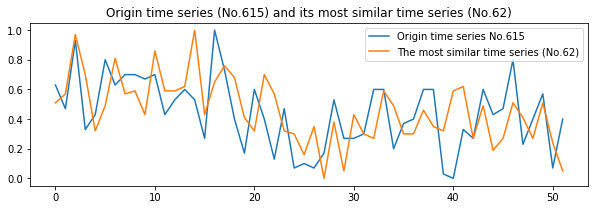

In [29]:
# Plot the most similar sales transaction (time series) to a sales transaction of our random choice.
idx_origin = random.sample(range(data.shape[0]), 1)[0]
idx_similar, d = get_most_similar(idx_origin, D_recovered)
print('The closest time series of transaction %d is transaction %d\
        and their distance is %f' %(idx_origin, idx_similar, d))
plt.figure(figsize = (10, 3))
plt.plot(data[idx_origin, :], label = 'Origin time series No.%d'%idx_origin)
plt.plot(data[idx_similar, :], label ='The most similar time series (No.%d)'%idx_similar)
plt.legend()
plt.title('Origin time series (No.%d) and its most similar time series (No.%d)'%(idx_origin, idx_similar))
plt.savefig('./data/two_similar_transactions.png')
plt.show()

## 3. Isomap
**Objective: Compute the dynamic time warping distance matrix between all 800 instances and try to embed these points in 2 dimensions using Isomap (you should implement it, not use scikitlean or other public implementations). Display these results.**

In [652]:
def dissimilarity(data):
    '''
        Return the dissimilarity between the points in matrix `data` (n_samples, n_features).
        Here, the dissimilarity is the Dynamic Time Warping Distance.
    '''
    print("data.shape:", data.shape)
    for i in range(n):
        for j in range(n):
            if i <= j:
                C = DTW(data[i], data[j])[data.shape[1]-1,data.shape[1]-1]
                D[i,j] = C
            else:
                D[i,j] = D[j,i]
    return D

- Compute the dissimilarity between all the pairs ($811\times811$). This takes about 4 hours.

In [ ]:
D = dissimilarity(data)

- Recover the dissimilarity matrix that we have saved.

In [25]:
D_recovered = np.load("./data/dissimilarity_matrix_20190519.npy")
D_recovered

array([[ 0.  ,  7.24, 10.49, ...,  9.97, 10.2 ,  9.03],
       [ 7.24,  0.  ,  9.34, ..., 10.3 , 10.6 , 10.56],
       [10.49,  9.34,  0.  , ..., 13.48, 12.58, 15.85],
       ...,
       [ 9.97, 10.3 , 13.48, ...,  0.  ,  4.  ,  4.74],
       [10.2 , 10.6 , 12.58, ...,  4.  ,  0.  ,  4.53],
       [ 9.03, 10.56, 15.85, ...,  4.74,  4.53,  0.  ]])

In [602]:
def gram(D):
    '''
        Return the Gram matrix associated with the dissimilarity matrix `D`.
    '''
    n = D.shape[0]
    P = np.identity(n) - np.ones((n,n))/n
    G = -1/2 * P.dot(D).dot(P)
    return G

In [603]:
def MDS(D, d=2):
    '''
        Compute the MDS of the dataset in matrix `data`(n_samples, n_features), with target dimension `d`.
    '''
    G = gram(D)
    eigenvalues, eigenvectors = np.linalg.eigh(G)
    
    return eigenvectors[:,-d:].dot(np.diag(np.sqrt(eigenvalues[-d:])))

In [604]:
data_reduced = MDS(D_recovered, d=2)

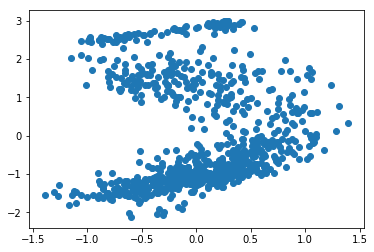

In [636]:
plt.scatter(data_reduced[:,0], data_reduced[:,1], cmap='hot')#, c=(y/np.max(y)))
plt.savefig('./data/isomap.png')
plt.show()

## 4. Multidimensional Scaling (MDS)
**Objective: Embed now these points in a higher dimension using still MDS (e.g. 5). Check that the stress you have found is indeed smaller. Use a simple k-means algorithm on these representations to gather these 800 observations in k subgroups (set k as you wish).**

In [606]:
data_reduced_5 = MDS(D_recovered, d=5)

- Compute the Nearest Neighbors Graph

For each point $i$ in the dataset, we will compute its $k$ nearest neighbors and draw an edge between $i$ and all its nearest neighbors.

In [623]:
def dissimilarity_euc(data):
    '''
        Return the dissimilarity between the points in matrix `data` (n_samples, n_features).
        Here, the dissimilarity is the squared Euclidean norm.
    '''
    data_sq = np.sum(data**2, 1)
    D = data_sq + data_sq[:, None] - 2 * data.dot(data.T)
    return D

In [624]:
def dissimilarity_sqrt(data):
    '''
        Return the Euclidean distance between the points in the dataset `data`.
    '''
    D = dissimilarity_euc(data)
    D = np.maximum(D, 0)
    return np.sqrt(D)

In [625]:
def B(Z, D):
    '''
        Return the matrix B in SMACOF iteration.
    '''
    A = -np.divide(D, dissimilarity_sqrt(Z)+1e-20) # Add 1e-20 for stability issues
    A = A - np.diag(np.sum(A,0))
    return A

In [630]:
def mMDS(data, d, N_iter=100, D_precomputed=None):
    '''
        Metric Multidimensional Scaling (mMDS)
        Compute the mMDS of the dataset `data`, with target dimension `d` and `N_iter` iterations in SMACOF.
    '''
    n = data.shape[0]
    
    # Initialize at random
    Z = np.random.normal(size=d*n).reshape([n,d])
    
    if D_precomputed is None:
        D = dissimilarity_sqrt(X)
    else:
        D = D_precomputed
    # Run the algorithm
    stress = []
    for i in range(N_iter):
        Z = B(Z,D).dot(Z)/n
        stress.append(np.sum(np.sum((D-dissimilarity_sqrt(Z))**2)))
    
    return Z, np.array(stress)/(n*n)

- Each of $d=2$ and $d=5$ takes a few minutes.

In [632]:
# k-Nearest-Neighbors
k = 3

Z2, stress2 = mMDS(data, d=2, N_iter=200, D_precomputed=D_recovered)
print('Stress value with d=2: ', stress2[-1])

Stress value with d=2:  5.453757726177226


In [633]:
Z5, stress5 = mMDS(data, d=5, N_iter=200, D_precomputed=D_recovered)
print('Stress value with d=5: ', stress5[-1])

Stress value with d=5:  1.9640749640978061


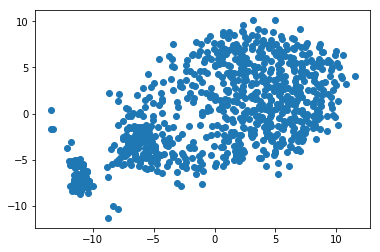

In [650]:
plt.scatter(Z2[:,0], Z2[:,1], cmap='hot')
plt.savefig('./data/MDS.png')
plt.show()

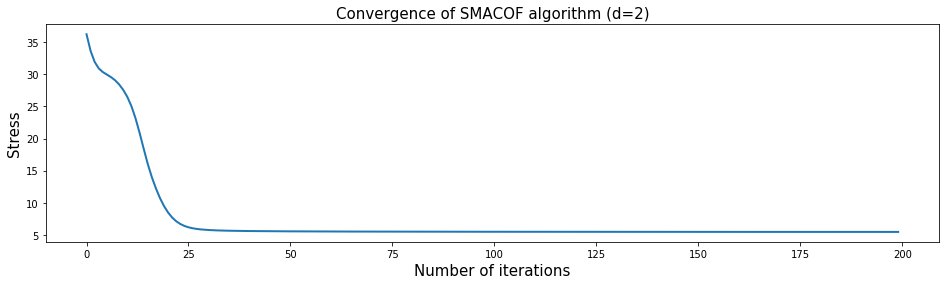

In [646]:
plt.figure(figsize=(16,4))
plt.title('Convergence of SMACOF algorithm (d=2)', fontsize=15)
plt.plot(stress2, lw=2)
plt.ylabel('Stress', fontsize=15)
plt.xlabel('Number of iterations', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('./data/Stress_Evolution_d2.png')
plt.show()

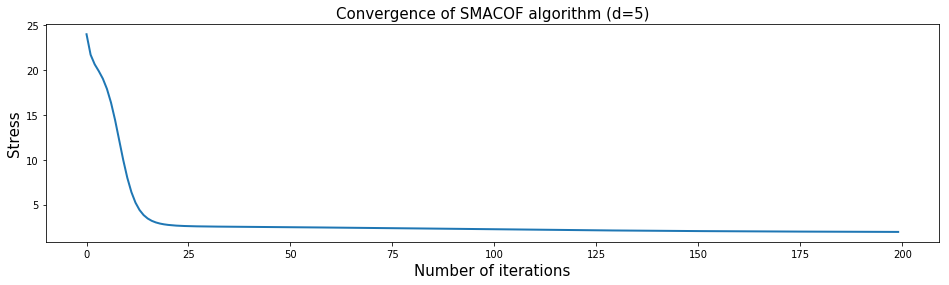

In [645]:
plt.figure(figsize=(16,4))
plt.title('Convergence of SMACOF algorithm (d=5)', fontsize=15)
plt.plot(stress5, lw=2)
plt.ylabel('Stress', fontsize=15)
plt.xlabel('Number of iterations', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('./data/Stress_Evolution_d5.png')
plt.show()

## 5. Time Series Averaging
**Objective: In order to visualize representative examples for each class in these samples, we consider time series averaging. We will compute an average for each of the k clusters computed in the previous question. Code to compute such averages is available in R or Python. Plot these averages and compare them with the usual Euclidean averaging you would obtain by simply summing these time-series.**

DTW Barycenter Averaging (DBA) 

In [71]:
from DBA import *

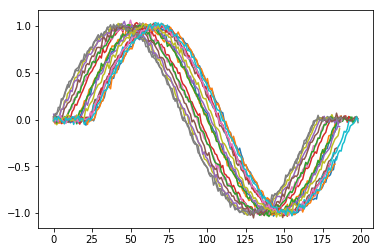

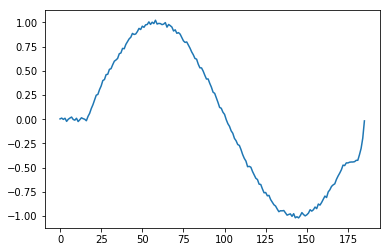

In [77]:
DBA.main()

In [72]:
t = np.arange(0, 5, 0.01)

In [73]:
def f(t, a) :
    return np.maximum(t-a, 0)*np.exp(-5*(t-a))

KeyboardInterrupt: 

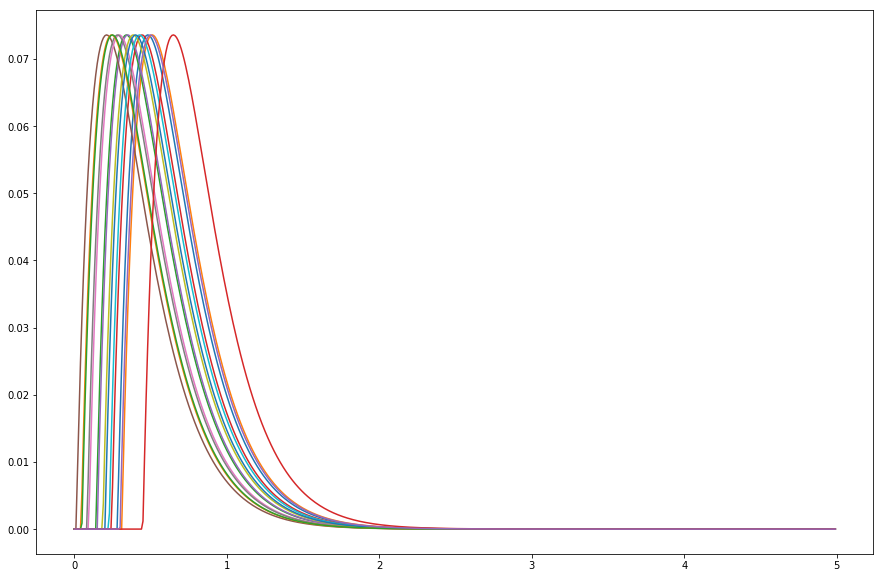

In [74]:
plt.figure(figsize=(15, 10))
mean = np.zeros(t.shape[0])
n = 15
series = list()
for i in range(n) :
    seriei = f(t, 0.5*np.random.rand())
    mean += seriei
    series.append(seriei)
    plt.plot(t, seriei)
average = performDBA(series, n_iterations=20)
plt.title('Arithmetic Averaging and DBA Averaging')
plt.plot(t, average, linewidth = 7, color = 'blue', label = 'Time Series DBA Averaging')
plt.plot(t, mean/n, linewidth = 7, color = 'black', label = 'Arithmetic Averaging')
plt.legend()
plt.show()

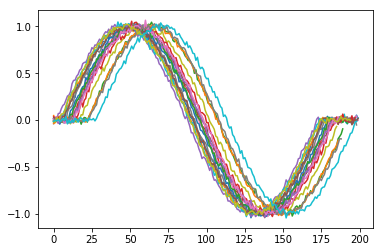

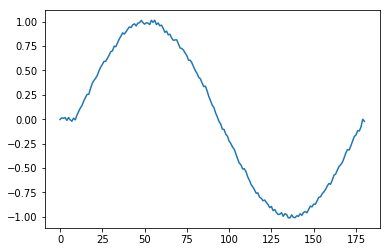

In [78]:
'''
/*******************************************************************************
 * Copyright (C) 2018 Francois Petitjean
 *
 * This program is free software: you can redistribute it and/or modify
 * it under the terms of the GNU General Public License as published by
 * the Free Software Foundation, version 3 of the License.
 *
 * This program is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU General Public License for more details.
 *
 * You should have received a copy of the GNU General Public License
 * along with this program.  If not, see <http://www.gnu.org/licenses/>.
 ******************************************************************************/
'''
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce


__author__ ="Francois Petitjean"

def performDBA(series, n_iterations=10):
    n_series = len(series)
    max_length = reduce(max, map(len, series))

    cost_mat = np.zeros((max_length, max_length))
    delta_mat = np.zeros((max_length, max_length))
    path_mat = np.zeros((max_length, max_length), dtype=np.int8)

    medoid_ind = approximate_medoid_index(series,cost_mat,delta_mat)
    center = series[medoid_ind]

    for i in range(0,n_iterations):
        center = DBA_update(center, series, cost_mat, path_mat, delta_mat)

    return center

def approximate_medoid_index(series,cost_mat,delta_mat):
    if len(series)<=50:
        indices = range(0,len(series))
    else:
        indices = np.random.choice(range(0,len(series)),50,replace=False)

    medoid_ind = -1
    best_ss = 1e20
    for index_candidate in indices:
        candidate = series[index_candidate]
        ss = sum_of_squares(candidate,series,cost_mat,delta_mat)
        if(medoid_ind==-1 or ss<best_ss):
            best_ss = ss
            medoid_ind = index_candidate
    return medoid_ind

def sum_of_squares(s,series,cost_mat,delta_mat):
    return sum(map(lambda t:squared_DTW(s,t,cost_mat,delta_mat),series))

def DTW(s,t,cost_mat,delta_mat):
    return np.sqrt(squared_DTW(s,t,cost_mat,delta_mat))

def squared_DTW(s,t,cost_mat,delta_mat):
    s_len = len(s)
    t_len = len(t)
    length = len(s)
    fill_delta_mat_dtw(s, t, delta_mat)
    cost_mat[0, 0] = delta_mat[0, 0]
    for i in range(1, s_len):
        cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]

    for j in range(1, t_len):
        cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]

    for i in range(1, s_len):
        for j in range(1, t_len):
            diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
            if(diag <=left):
                if(diag<=top):
                    res = diag
                else:
                    res = top
            else:
                if(left<=top):
                    res = left
                else:
                    res = top
            cost_mat[i, j] = res+delta_mat[i, j]
    return cost_mat[s_len-1,t_len-1]

def fill_delta_mat_dtw(center, s, delta_mat):
    slim = delta_mat[:len(center),:len(s)]
    np.subtract.outer(center, s,out=slim)
    np.square(slim, out=slim)

def DBA_update(center, series, cost_mat, path_mat, delta_mat):
    options_argmin = [(-1, -1), (0, -1), (-1, 0)]
    updated_center = np.zeros(center.shape)
    n_elements = np.array(np.zeros(center.shape), dtype=int)
    center_length = len(center)
    for s in series:
        s_len = len(s)
        fill_delta_mat_dtw(center, s, delta_mat)
        cost_mat[0, 0] = delta_mat[0, 0]
        path_mat[0, 0] = -1

        for i in range(1, center_length):
            cost_mat[i, 0] = cost_mat[i-1, 0]+delta_mat[i, 0]
            path_mat[i, 0] = 2

        for j in range(1, s_len):
            cost_mat[0, j] = cost_mat[0, j-1]+delta_mat[0, j]
            path_mat[0, j] = 1

        for i in range(1, center_length):
            for j in range(1, s_len):
                diag,left,top =cost_mat[i-1, j-1], cost_mat[i, j-1], cost_mat[i-1, j]
                if(diag <=left):
                    if(diag<=top):
                        res = diag
                        path_mat[i,j] = 0
                    else:
                        res = top
                        path_mat[i,j] = 2
                else:
                    if(left<=top):
                        res = left
                        path_mat[i,j] = 1
                    else:
                        res = top
                        path_mat[i,j] = 2

                cost_mat[i, j] = res+delta_mat[i, j]

        i = center_length-1
        j = s_len-1

        while(path_mat[i, j] != -1):
            updated_center[i] += s[j]
            n_elements[i] += 1
            move = options_argmin[path_mat[i, j]]
            i += move[0]
            j += move[1]
        assert(i == 0 and j == 0)
        updated_center[i] += s[j]
        n_elements[i] += 1

    return np.divide(updated_center, n_elements)

def main():
    #generating synthetic data
    n_series = 20
    length = 200

    series = list()
    padding_length=30
    indices = range(0, length-padding_length)
    main_profile_gen = np.array([np.sin(2*np.pi*j/len(indices)) for j in indices])
    randomizer = lambda j:np.random.normal(j,0.02)
    randomizer_fun = np.vectorize(randomizer)
    for i in range(0,n_series):
        n_pad_left = np.random.randint(0,padding_length)
        #adding zero at the start or at the end to shif the profile
        series_i = np.pad(main_profile_gen,(n_pad_left,padding_length-n_pad_left),mode='constant',constant_values=0)
        #chop some of the end to prove it can work with multiple lengths
        l = np.random.randint(length-20,length+1)
        series_i = series_i[:l]
        #randomize a bit
        series_i = randomizer_fun(series_i)

        series.append(series_i)
    series = np.array(series)

    #plotting the synthetic data
    for s in series:
        plt.plot(range(0,len(s)), s)
    plt.draw()

    #calculating average series with DBA
    average_series = performDBA(series)

    #plotting the average series
    plt.figure()
    plt.plot(range(0,len(average_series)), average_series)
    plt.show()

if __name__== "__main__":
    main()
